In [14]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv('data/train.csv')

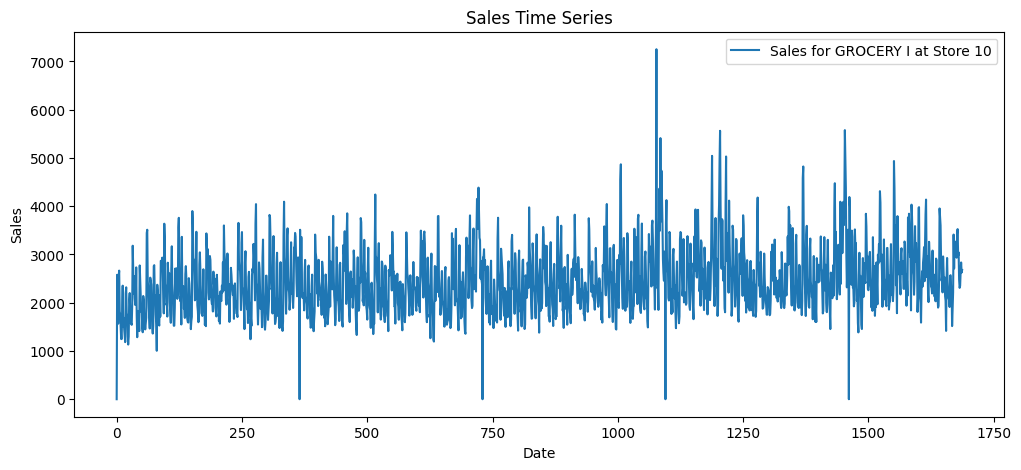

In [31]:
store_number = 10  # Change this to the desired store
product_family = "GROCERY I"  # Change this to the desired product family

df_filtered = df[(df["store_nbr"] == store_number) & (df["family"] == product_family)].copy()

# Set the date as the index
dates_dt = pd.to_datetime(df_filtered['date'])
dates_dt_min = dates_dt.min()
days = (dates_dt - dates_dt_min).dt.days
df_filtered['day'] = days
df_filtered.set_index("day", inplace=True)

# Keep only the sales column
df_filtered = df_filtered[["sales"]]

# Sort
df_filtered = df_filtered.sort_index()

# Visualize sales over time
plt.figure(figsize=(12, 5))
plt.plot(df_filtered, label=f"Sales for {product_family} at Store {store_number}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Time Series")
plt.legend()
plt.show()

ADF Statistic: -6.071949674558721
p-value: 1.1452419390349338e-07
The data is stationary.
ADF Statistic: -15.634152606695531
p-value: 1.6710943913707734e-28
The data is stationary.


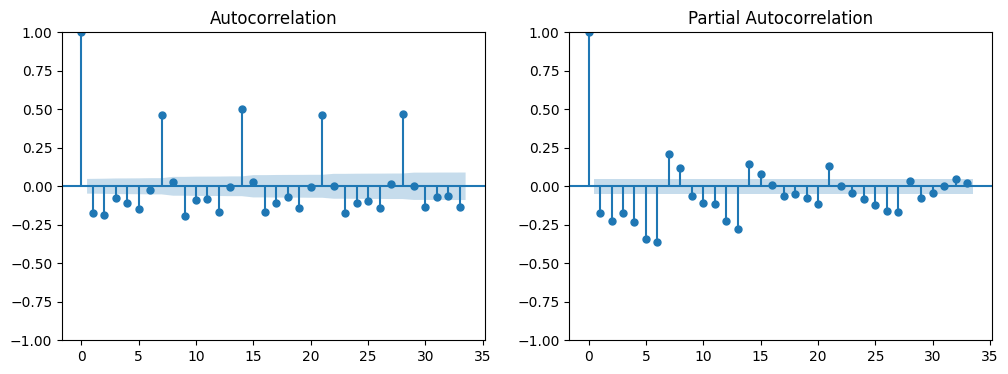

C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1684
Model:                ARIMA(2, 1, 30)   Log Likelihood              -12844.793
Date:                Sat, 15 Feb 2025   AIC                          25755.587
Time:                        15:34:59   BIC                          25934.722
Sample:                             0   HQIC                         25821.937
                               - 1684                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1934      0.179     -1.078      0.281      -0.545       0.158
ar.L2          0.6060      0.167      3.621      0.000       0.278       0.934
ma.L1         -0.3836      0.177     -2.168      0.0

C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


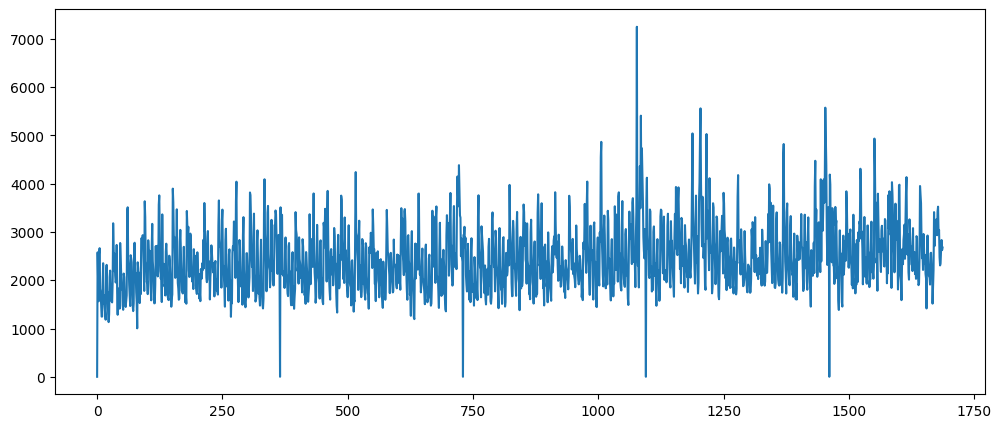

In [32]:
# This is the implementation of the ARIMA model(this model does not take into account promotion data nor oil prizes, to be modified accordingly)

# First we check if the data is stationary; for it take the following function based on the Augmented Dickey-Fuller (ADF) Test (here DataTrain is replaced with "df" for simplicity, as is the rest of the code)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is NOT stationary. Differencing must be done.")

# Run the ADF test
adf_test(df_filtered["sales"])


# Carry out differencing

df_filtered["sales_diff"] = df_filtered["sales"].diff().dropna()
adf_test(df_filtered["sales_diff"].dropna())  


# Determine ARIMA parameters(for it we need these plots)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_filtered["sales_diff"].dropna(), ax=axes[0])  # q value (MA component)
plot_pacf(df_filtered["sales_diff"].dropna(), ax=axes[1])  # p value (AR component)
plt.show()


# fit model

p, d, q = 2, 1, 30  # Adjust based on ACF/PACF values above, most likely not these

model = ARIMA(df_filtered["sales"], order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


# To make predictions we forecast after N days

# Forecasting 30 days into the future
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Create future dates in dates format
future_dates = pd.date_range(start=df_filtered.index[-1], periods=forecast_steps + 1, freq="D")[1:]

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({"date": future_dates, "predicted_sales": forecast.values})

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(df_filtered.index, df_filtered["sales"], label="Historical Sales")
# plt.plot(forecast_df["date"], forecast_df["predicted_sales"], label="Forecast", linestyle="dashed", color="red")
# plt.xlabel("Date")
# plt.ylabel("Sales")
# plt.title(f"Sales Forecast for {product_family} at Store {store_number}")
# plt.legend()
# plt.show()

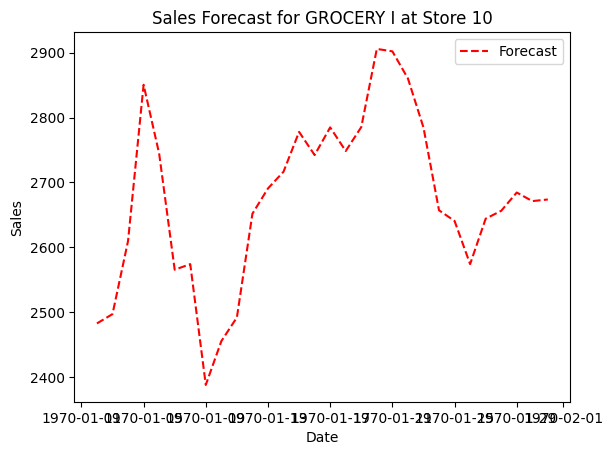

In [34]:
plt.plot(forecast_df["date"], forecast_df["predicted_sales"], label="Forecast", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"Sales Forecast for {product_family} at Store {store_number}")
plt.legend()
plt.show()